In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from utils import *
import glob

In [2]:
client=get_cluster()

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43817 instead
  warnings.warn(


In [5]:
help(get_files)

Help on function get_files in module utils:

get_files(exp, cmp='/lnd/', tape='h0')



In [16]:
help(get_ds)

Help on function get_ds in module utils:

get_ds(exp, dvs, cmp='/lnd/', tape='h0', a=slice(10, 60, None), o=slice(225, 300, None), parallel=True)



In [89]:
tcces=[]
for yr in [1850,2020,2090]:
    print(yr)
    ds=get_ds(str(yr)+'_era5_i04',['TREFHTMX'],cmp='/atm/',tape='h1')
    la=get_foco(ds)*np.cos(np.deg2rad(ds.lat))
    ixt=(ds['time.month']>=7)&(ds['time.month']<=9)
    tcce=gmean(ds.TREFHTMX.isel(time=ixt).mean(dim='time'),la)
    tcces.append(tcce)

1850
2020
2090


In [98]:
tlenss=[]
for yr in [1850,2020,2090]:
    print(yr)
    lens=get_ds(str(yr)+'_lens',['TREFHTMX'],cmp='/atm/',tape='h1')
    la=get_foco(lens)*np.cos(np.deg2rad(lens.lat))
    ixt=(lens['time.month']>=7)&(lens['time.month']<=9)
    tlens=gmean(lens.TREFHTMX.isel(time=ixt).groupby('time.year').mean(),la)
    tlenss.append(tlens)
    

1850


/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2020


/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


2090


/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 35.05 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [93]:
yrs=[1850,2020,2090]

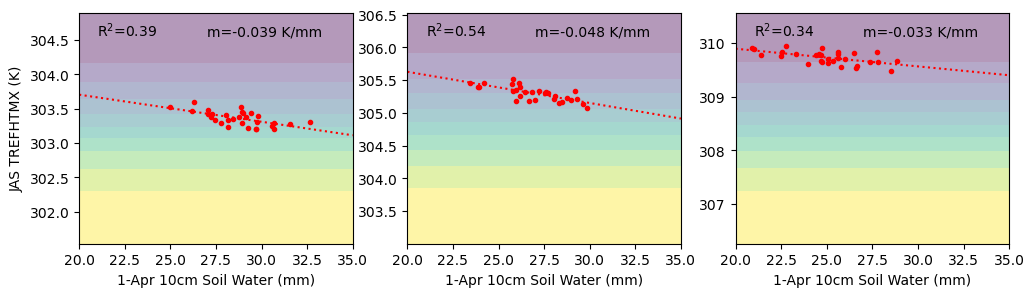

In [105]:
plt.figure(figsize=[12,3])
i=0
ymin,ymax=np.inf,-np.inf
for ylens,ycce,yr in zip(tlenss,tcces,yrs):
    i+=1
    plt.subplot(130+i)
    m,r2,p,y0,y1=iplot(ylens,ycce,yr)
    plt.xlabel('1-Apr 10cm Soil Water (mm)');
    if i==1:
        plt.ylabel('JAS TREFHTMX (K)')

    yy=y0+0.9*(y1-y0)
    plt.text(21,yy,'R$^2$='+str(np.round(r2,2)))
    plt.text(27,yy,'m='+str(np.round(m,3))+' K/mm')
    plt.ylim([y0,y1])

plt.savefig('../figs/inits/TREFHTMX.png',dpi=300,bbox_inches='tight')


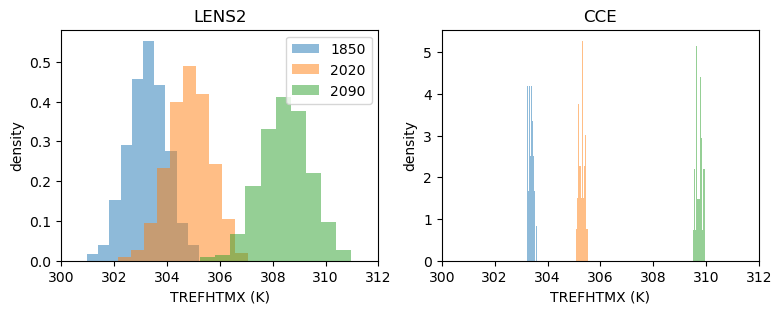

In [123]:
plt.figure(figsize=[9,3])
plt.subplot(121)
for t,yr in zip(tlenss,yrs):
    plt.hist(t.values.ravel(),density=True,alpha=0.5,label=yr);
plt.legend(yrs)
plt.title('LENS2')
plt.xlabel('TREFHTMX (K)')
plt.ylabel('density')
plt.xlim([300,312])
plt.subplot(122)
for t,yr in zip(tcces,yrs):
    plt.hist(t.values.ravel(),density=True,alpha=0.5,label=yr);

plt.title('CCE')
plt.xlabel('TREFHTMX (K)')
plt.ylabel('density')
plt.xlim([300,312])
plt.savefig('../figs/hists/TREFHTMX.png',dpi=300,bbox_inches='tight')

In [27]:
f='/glade/derecho/scratch/djk2120/postp/jas/cce_era5_i04.nc'
cce=xr.open_dataset(f)

In [123]:
d='/glade/derecho/scratch/djk2120/postp/jas/'
ds=xr.Dataset()
dvs=['ET','PREC','NBP','QRUNOFF','VP','SOILWATER_10CM','TWS']
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords')[v]


In [124]:
cfs={v:24*60*60*92 for v in ['ET','PREC','QRUNOFF','NBP']}
cfs['SOILWATER_10CM']=1
cfs['TWS']=1
cfs['VP']=1000

units={v:'mm' for v in ['ET','PREC','QRUNOFF','SOILWATER_10CM','TWS']}
units['NBP']='gC/m2'
units['VP']='Pa'

In [54]:
ylens=tlens

In [55]:
ycce=tcce

In [70]:
def iplot(ylens,ycce,yr):

    cmap=plt.get_cmap('viridis_r',10)
    x=np.array([20,35])
    qlocs=[1/100,*0.1+np.arange(9)/10,99/100]
    qs=ylens.quantile(qlocs)
        
    for i in range(10):
        plt.fill_between(x,[qs[i],qs[i]],[qs[i+1],qs[i+1]],color=cmap(i),alpha=0.4,lw=0)   
    
    x0=cce.SW4.sel(year=yr)
            
    plt.plot(x0,ycce,'r.')
    m,b,r,p,stderr=stats.linregress(x0,ycce)
    if p<0.05:
        plt.plot(x,m*x+b,'r:')
    plt.xlim(x)
    
    ymin=min(min(qs),ycce.min())
    ymax=max(max(qs),ycce.max())
    
    return m,r**2,p,ymin,ymax


In [120]:
def iplot(v,cf,u,round=3):
    
    ymin,ymax=np.inf,-np.inf
    plt.figure(figsize=[12,3])
    ms=[]
    r2s=[]
    ps=[]
    for j,yr in enumerate([1850,2020,2090]):
        plt.subplot(131+j)
    
        ylens=cf*ds[v].sel(year=slice(yr-10,yr+10)).chunk(dict(year=-1))
        ycce=cf*cce[v].sel(year=yr)
        
        m,r2,p,y0,y1=iplot(ylens,ycce,2020)
        ms.append(m)
        r2s.append(r2)
        ps.append(p)
        
        ymin=min(ymin,y0)
        ymax=max(ymax,y1)
        
        plt.xlabel('1-Apr 10cm Soil Water (mm)');
        if j==0:
            plt.ylabel('JAS '+v+' ('+u+')')
        plt.title(yr)
    for i in range(3):
        plt.subplot(131+i)
        dy=ymax-ymin
        plt.ylim([ymin-0.02*dy,ymax+0.02*dy])
        plt.text(21,ymax-0.1*dy,'R$^2$='+str(np.round(r2s[i],2)))
        if ps[i]<0.05:
            plt.text(26,ymax-0.1*dy,'slope='+str(np.round(ms[i],round))+' '+u+'/mm')

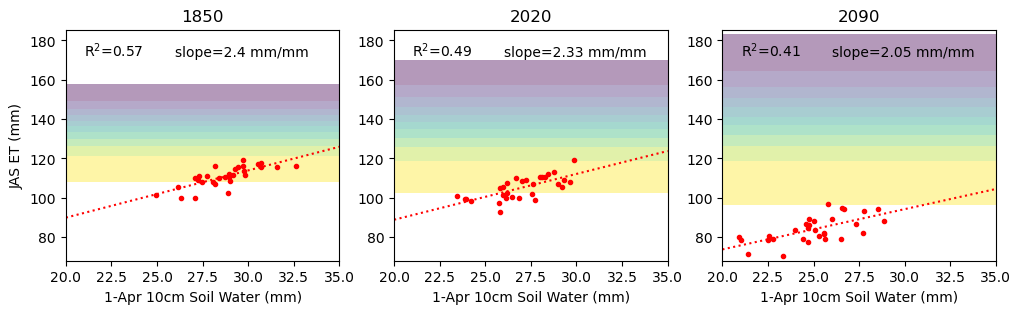

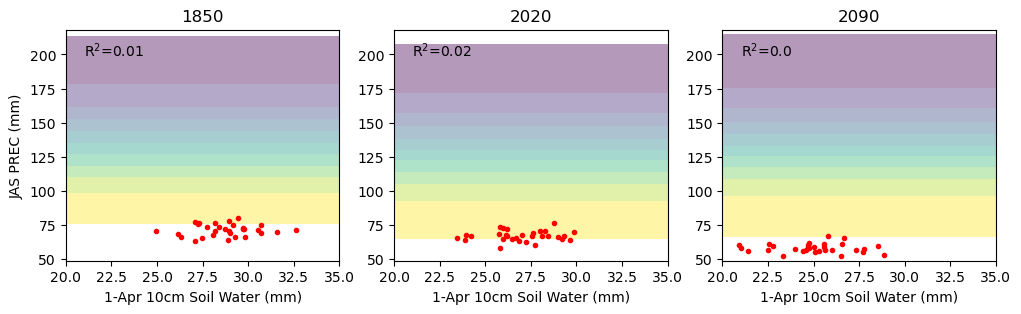

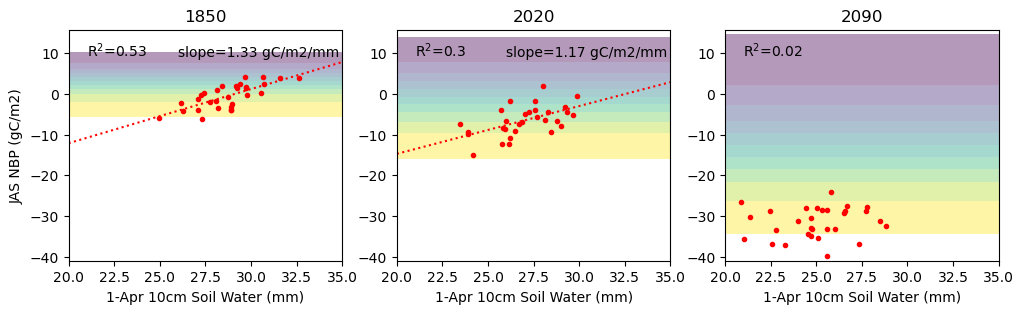

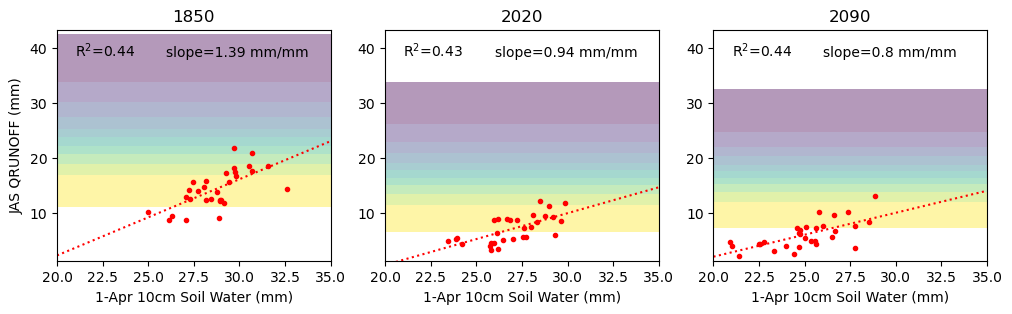

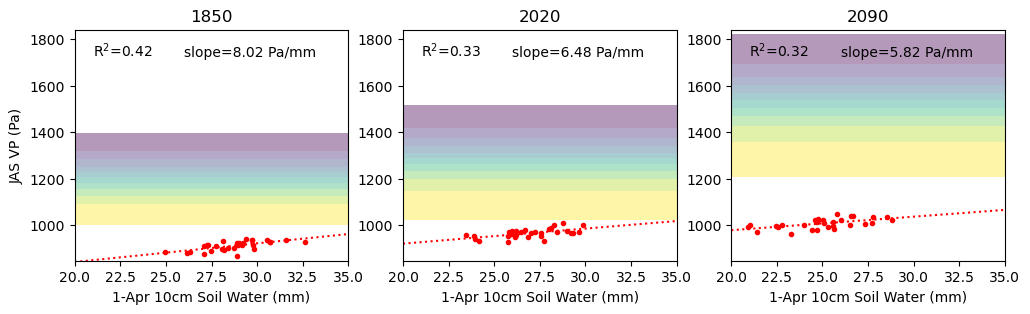

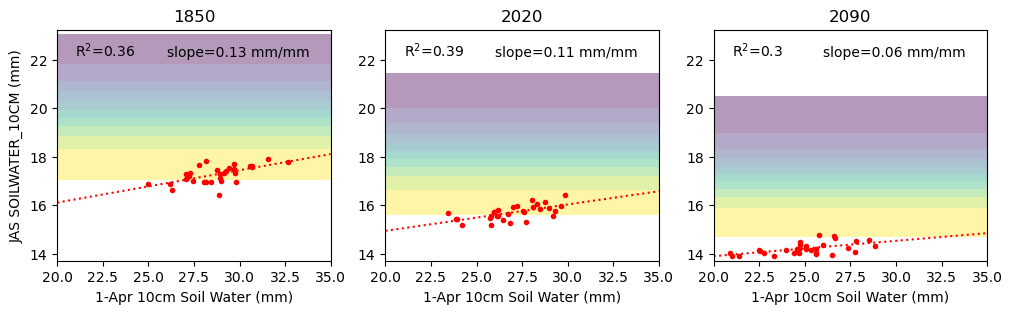

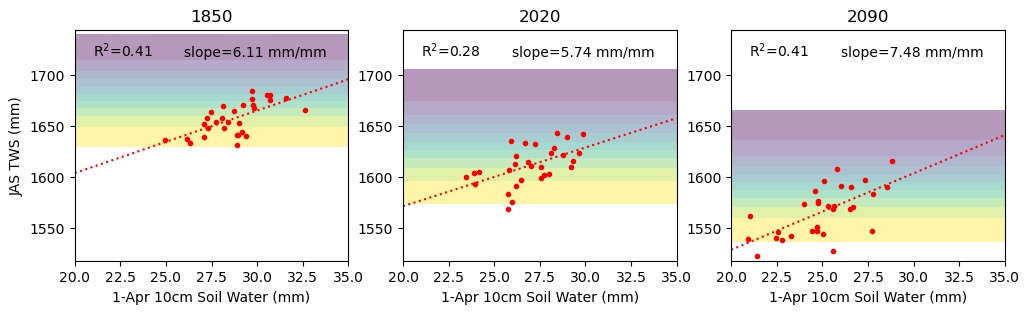

In [126]:
for v in dvs:
    iplot(v,cfs[v],units[v],round=2)
    plt.savefig('../figs/inits/'+v+'.png',dpi=300,bbox_inches='tight')

In [43]:
cce.SW4.max()

<xarray.DataArray 'SW4' ()>
array(32.63655759)

In [40]:
#read in the constrained circulation sw10cm data
sw0s={}
for yr in [2020,2090]:
    files=get_files(str(yr)+'_era5_i04',tape='h1')
    files=[f[0] for f in files]
    tmp=xr.open_dataset(files[0])
    la=get_foco(tmp)*tmp.area*tmp.landfrac
    def pp(ds):
        return gmean(ds.SOILWATER_10CM,la)
    sw0=xr.open_mfdataset(files,combine='nested',concat_dim='ens',preprocess=pp,parallel=True).isel(time=0)
    sw0s[yr]=sw0

(array([3., 1., 2., 2., 6., 6., 2., 3., 3., 2.]),
 array([20.89198086, 21.68663192, 22.48128297, 23.27593403, 24.07058509,
        24.86523614, 25.6598872 , 26.45453826, 27.24918931, 28.04384037,
        28.83849143]),
 <BarContainer object of 10 artists>)

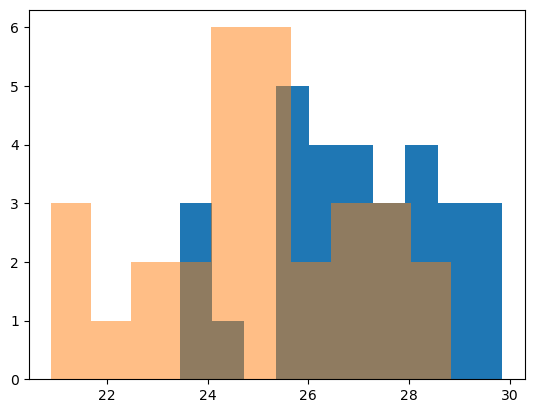

In [55]:
plt.hist(sw0s[2020])
plt.hist(sw0s[2090],alpha=0.5)

In [6]:
#read in LENS2
extras=['PREC','ET','VPD','VP']
dsets=[get_ds(str(yr)+'_lens',dvs) for yr in range(2000,2040,10)]
ds=xr.concat(dsets,dim='time')[[*dvs,*extras]].sel(time=slice('2005','2034'))

In [7]:
plotmes=['SOILWATER_10CM','PREC','ET','TSA','NBP','QRUNOFF']
jas={}
cces={}
for v in plotmes:
    print(v)
    jas[v]=get_jas(ds[v],la)
    cces[v]=get_jas(cce[v],la)

SOILWATER_10CM
PREC
ET
TSA
NBP
QRUNOFF


In [12]:
cfs={'ET':24*60*60*92,'PREC':24*60*60*92,'QRUNOFF':24*60*60*92,
     'NBP':1e-6*24*60*60*92*la.sum()}
units=['mm','mm','mm','K','MtC','mm']

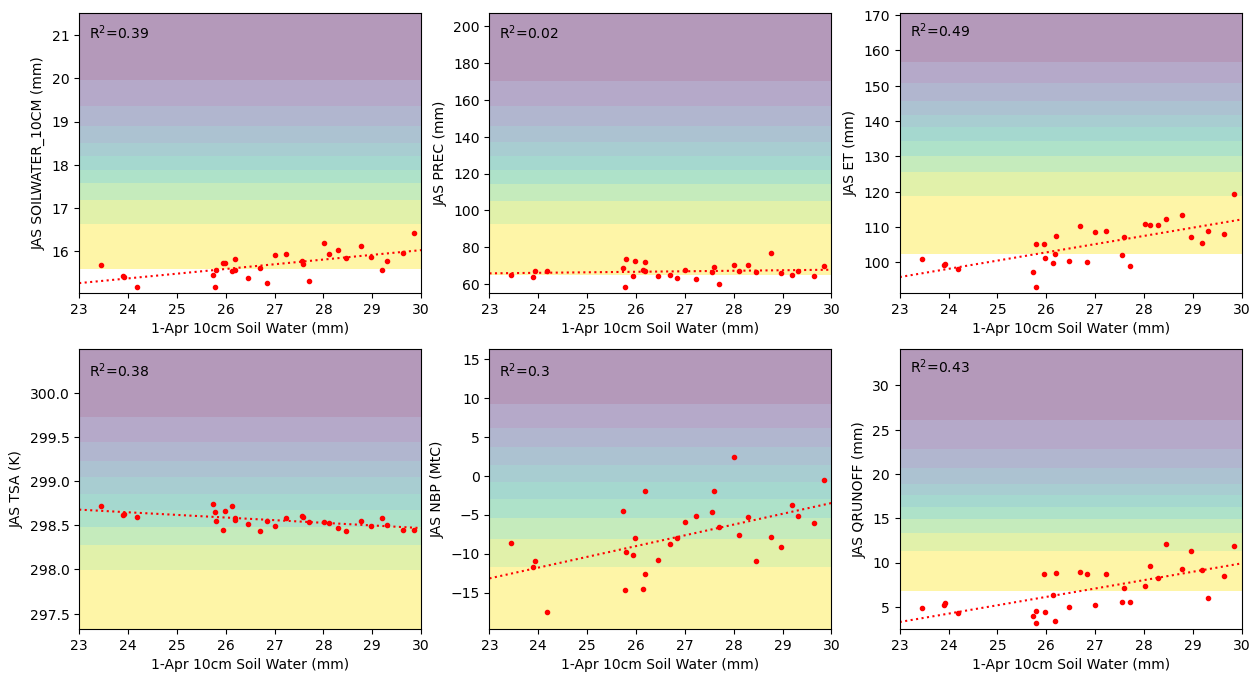

In [15]:
plt.figure(figsize=[15,8])
for i,v in enumerate(plotmes):
    plt.subplot(2,3,i+1)
    if v in cfs:
        cf=cfs[v]
    else:
        cf=1
    inits_plot(cf*jas[v],cf*cces[v],sw0)
    plt.ylabel('JAS '+v+' ('+units[i]+')')
plt.savefig('/glade/u/home/djk2120/mapp_new/figs/main/inits.pdf',bbox_inches='tight')

### plotting

In [241]:
cmap=plt.get_cmap('viridis_r',10)
qlocs=[1/1000,*0.1+np.arange(9)/10,999/1000]
x=np.array([23,30])

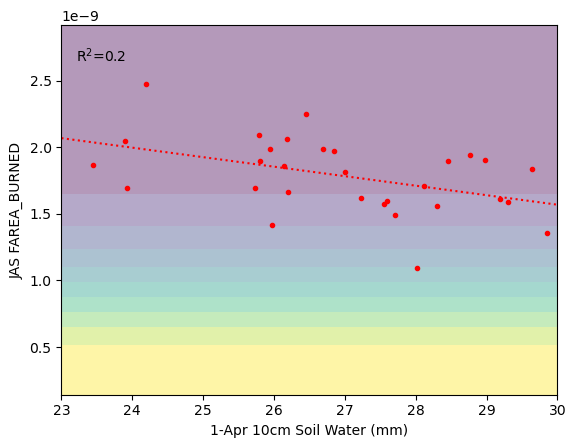

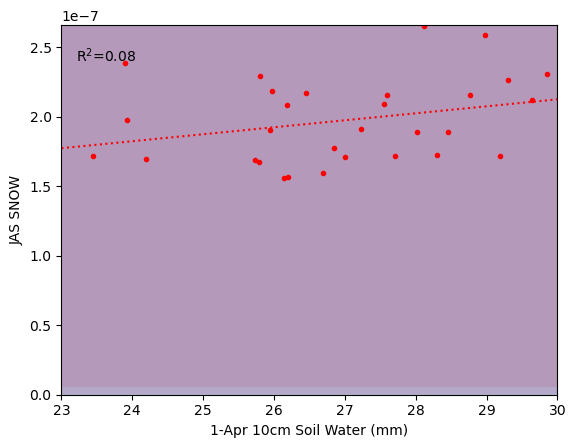

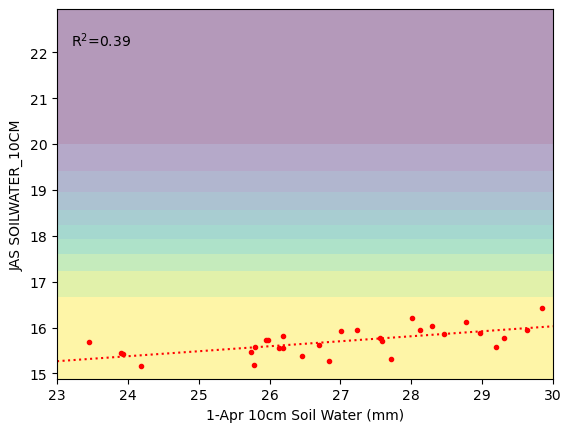

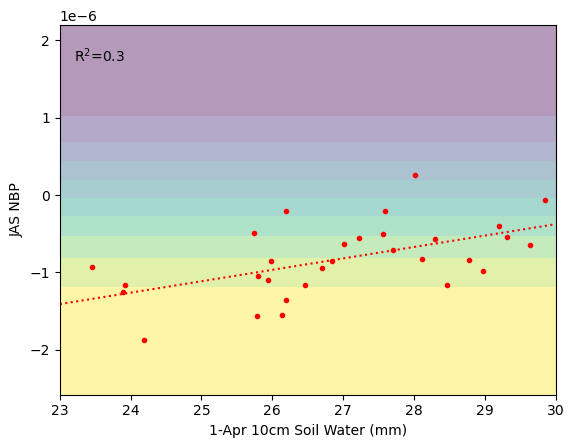

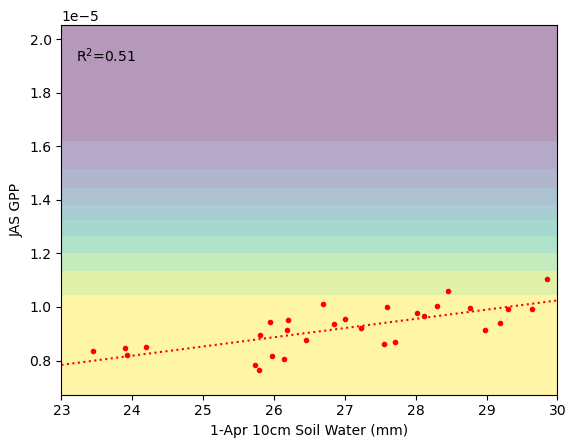

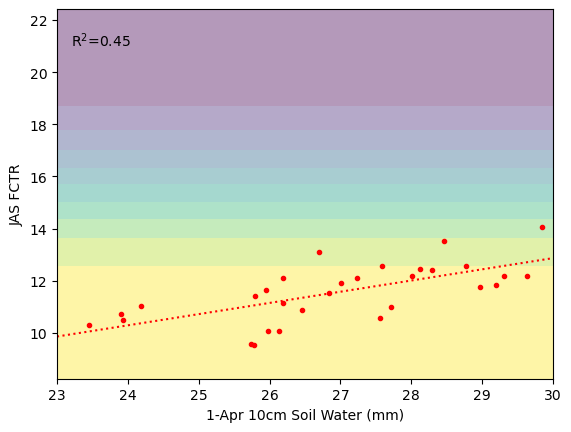

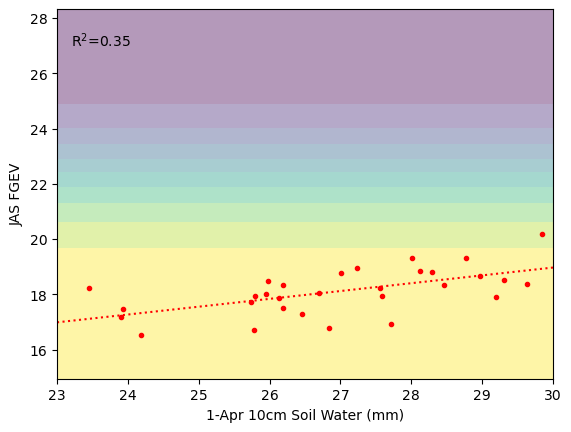

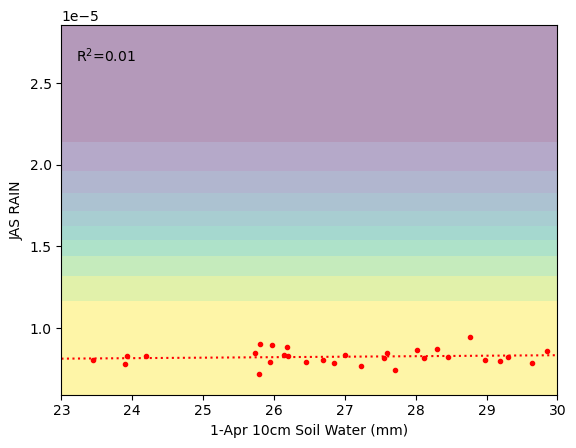

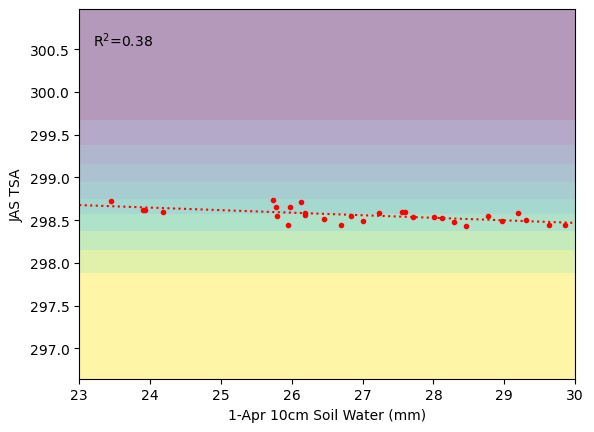

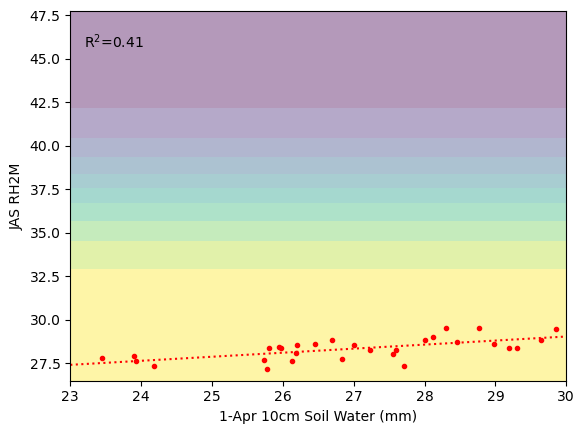

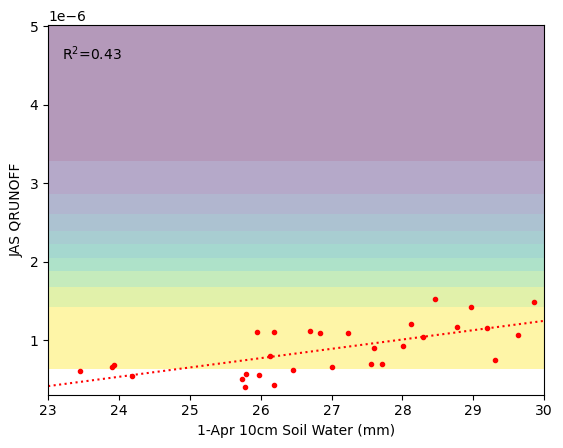

In [342]:
for v in dvs:
    plt.figure()
    qs=ds[v].quantile(qlocs)
    for i in range(10):
        plt.fill_between(x,[qs[i],qs[i]],[qs[i+1],qs[i+1]],color=cmap(i),alpha=0.4,lw=0)
    plt.plot(sw0,cce[v],'r.')
    m,b,r,p,stderr=stats.linregress(sw0,cce[v])
    plt.plot(x,m*x+b,'r:')
    plt.xlim(x)
    if qs[0]<cce[v].min():
        plt.ylim([qs[0],qs[-1]])
    else:
        plt.ylim([cce[v].min()-0.02*(qs[-1]-cce[v].min()),qs[-1]])
    qq=qs[0]+0.9*(qs[-1]-qs[0])
    r2=str(np.round(r**2,2))
    plt.text(23.2,qq,'R$^2$='+r2)
    plt.xlabel('1-Apr 10cm Soil Water (mm)')
    plt.ylabel('JAS '+v);
    plt.savefig('../figs/inits/'+v+'_init.png',dpi=300,bbox_inches='tight')